In [1]:
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
        print(dirname)

/kaggle/input
/kaggle/input/siim-isic-melanoma-classification
/kaggle/input/siim-isic-melanoma-classification/train
/kaggle/input/siim-isic-melanoma-classification/tfrecords
/kaggle/input/siim-isic-melanoma-classification/jpeg
/kaggle/input/siim-isic-melanoma-classification/jpeg/train
/kaggle/input/siim-isic-melanoma-classification/jpeg/test
/kaggle/input/siim-isic-melanoma-classification/test


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
%matplotlib inline

# Exploratory Data Analysis and Pre-Processing

## dicom format : 

A DICOM file is an image saved in the Digital Imaging and Communications in Medicine (DICOM) format. It contains an image from a medical scan, such as an ultrasound or MRI. **

In [3]:
train = pd.DataFrame(pd.read_csv("/kaggle/input/siim-isic-melanoma-classification/train.csv"))
test = pd.DataFrame(pd.read_csv("/kaggle/input/siim-isic-melanoma-classification/test.csv"))

In [4]:
train.shape, test.shape

((33126, 8), (10982, 5))

So, there are around 33k training images and about 10k testing images

In [5]:
train.head()

,image_name,patient_id,sex,age_approx,anatom_site_general_challenge,diagnosis,benign_malignant,target
0,ISIC_2637011,IP_7279968,male,45.0,head/neck,unknown,benign,0
1,ISIC_0015719,IP_3075186,female,45.0,upper extremity,unknown,benign,0
2,ISIC_0052212,IP_2842074,female,50.0,lower extremity,nevus,benign,0
3,ISIC_0068279,IP_6890425,female,45.0,head/neck,unknown,benign,0
4,ISIC_0074268,IP_8723313,female,55.0,upper extremity,unknown,benign,0


In [6]:
test.head()

,image_name,patient_id,sex,age_approx,anatom_site_general_challenge
0,ISIC_0052060,IP_3579794,male,70.0,NaN
1,ISIC_0052349,IP_7782715,male,40.0,lower extremity
2,ISIC_0058510,IP_7960270,female,55.0,torso
3,ISIC_0073313,IP_6375035,female,50.0,torso
4,ISIC_0073502,IP_0589375,female,45.0,lower extremity


In [7]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 33126 entries, 0 to 33125
Data columns (total 8 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   image_name                     33126 non-null  object 
 1   patient_id                     33126 non-null  object 
 2   sex                            33061 non-null  object 
 3   age_approx                     33058 non-null  float64
 4   anatom_site_general_challenge  32599 non-null  object 
 5   diagnosis                      33126 non-null  object 
 6   benign_malignant               33126 non-null  object 
 7   target                         33126 non-null  int64  
dtypes: float64(1), int64(1), object(6)
memory usage: 2.0+ MB


Every patient has an ID, however it might be that one patient may have multiple wound records. Let's fish that out.

In [8]:
len(train["patient_id"].unique())

2056

In [9]:
train["target"].value_counts()

0    32542
1      584
Name: target, dtype: int64

### Distribution Observation

Malignant VS Benign cases - OVERALL

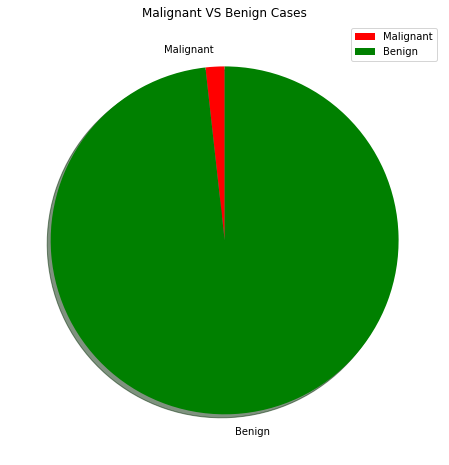

In [10]:
malignant = len(train[train["target"] == 1])
benign = len(train[train["target"] == 0])

labels = ["Malignant", "Benign"] 
size = [malignant, benign]

plt.figure(figsize = (8, 8))
plt.pie(size, labels = labels, shadow = True, startangle = 90, colors = ["r", "g"])
plt.title("Malignant VS Benign Cases")
plt.legend()

Malignant male cases VS female cases

Malignant Male Cases =  364
Malignant Female Cases =  220


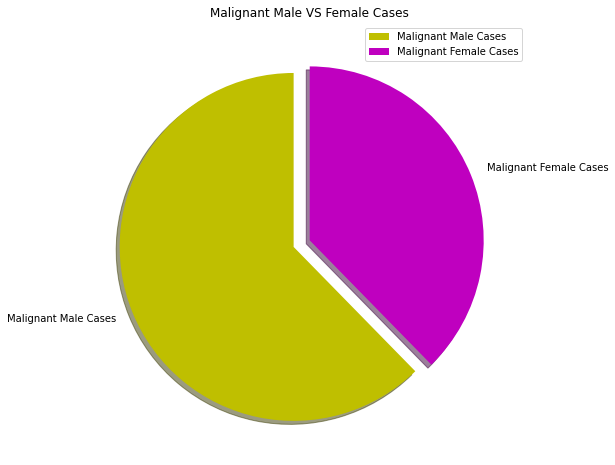

In [11]:
malignant  = train[train["target"] == 1]

malignant_males = len(malignant[malignant["sex"] == "male"])
malignant_females  = len(malignant[malignant["sex"] == "female"])

labels = ["Malignant Male Cases", "Malignant Female Cases"] 
size = [malignant_males, malignant_females]
explode = [0.1, 0.0]

plt.figure(figsize = (8, 8))
plt.pie(size, labels = labels, explode = explode, shadow = True, startangle = 90, colors = ["y", "m"])
plt.title("Malignant Male VS Female Cases")
plt.legend()
print("Malignant Male Cases = ", malignant_males)
print("Malignant Female Cases = ", malignant_females)

Benign male cases vs female cases

Benign Male Cases =  16716
Benign Female Cases =  15761


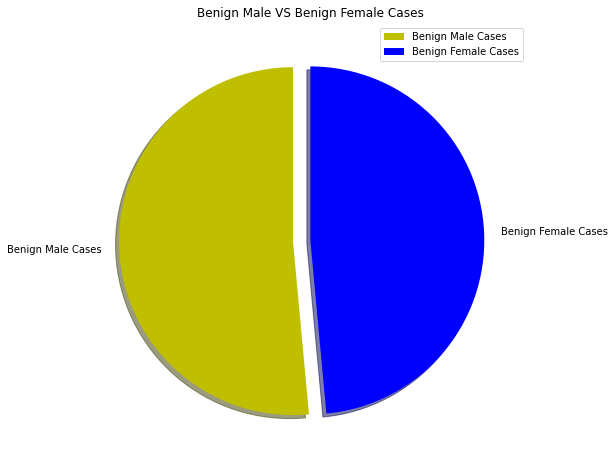

In [12]:
benign  = train[train["target"] == 0]

benign_males = len(benign[benign["sex"] == "male"])
benign_females  = len(benign[benign["sex"] == "female"]) 

labels = ["Benign Male Cases", "Benign Female Cases"] 
size = [benign_males, benign_females]
explode = [0.1, 0.0]

plt.figure(figsize = (8, 8))
plt.pie(size, labels = labels, explode = explode, shadow = True, startangle = 90, colors = ["y", "b"])
plt.title("Benign Male VS Benign Female Cases")
plt.legend()
print("Benign Male Cases = ", benign_males)
print("Benign Female Cases = ", benign_females)

In [13]:
print(train["anatom_site_general_challenge"].unique())
print(train["anatom_site_general_challenge"].value_counts())

['head/neck' 'upper extremity' 'lower extremity' 'torso' nan 'palms/soles'
 'oral/genital']
torso              16845
lower extremity     8417
upper extremity     4983
head/neck           1855
palms/soles          375
oral/genital         124
Name: anatom_site_general_challenge, dtype: int64


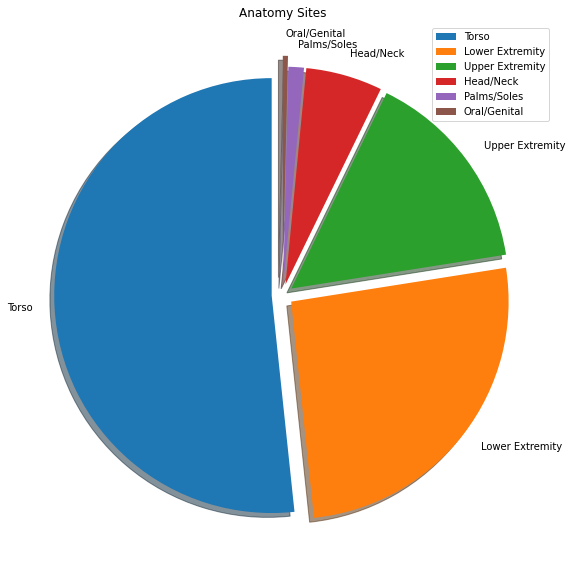

In [14]:
torso = len(train[train["anatom_site_general_challenge"] == "torso"])
lower_extremity = len(train[train["anatom_site_general_challenge"] == "lower extremity"])
upper_extremity = len(train[train["anatom_site_general_challenge"] == "upper extremity"])
head_neck = len(train[train["anatom_site_general_challenge"] == "head/neck"])
palms_soles = len(train[train["anatom_site_general_challenge"] == "palms/soles"])
oral_genital = len(train[train["anatom_site_general_challenge"] == "oral/genital"])

labels = ["Torso", "Lower Extremity", "Upper Extremity", "Head/Neck", "Palms/Soles", "Oral/Genital"] 
size = [torso,lower_extremity, upper_extremity, head_neck, palms_soles, oral_genital]
explode = [0.05, 0.05, 0.05, 0.05, 0.05, 0.1]
plt.figure(figsize = (12, 10))
plt.pie(size, labels = labels, explode = explode, shadow = True, startangle = 90)
plt.title("Anatomy Sites")
plt.legend()

Text(0.5, 1.0, 'Probabilistic Age Distribution')

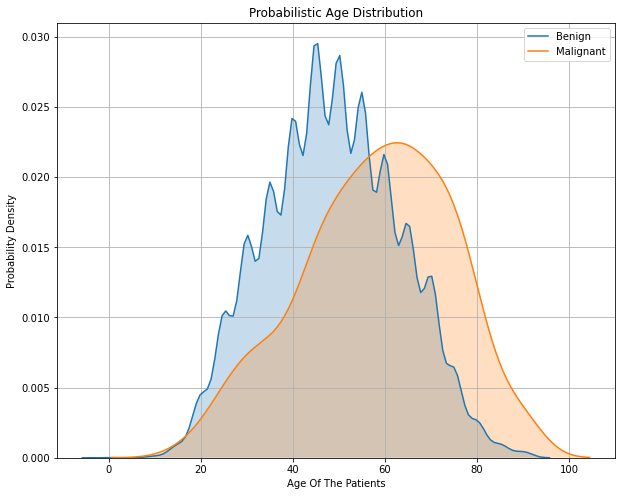

In [15]:
ages_benign = train.loc[train["target"] == 0, "age_approx"]
ages_malignant = train.loc[train["target"] == 1 , "age_approx"]

plt.figure(figsize = (10, 8))
sns.kdeplot(ages_benign, label = "Benign", shade = True, legend = True, cbar = True)
sns.kdeplot(ages_malignant, label = "Malignant", shade = True, legend = True, cbar = True)
plt.grid(True)
plt.xlabel("Age Of The Patients")
plt.ylabel("Probability Density")
plt.grid(which = "minor", axis = "both")
plt.title("Probabilistic Age Distribution")

In [16]:
image_names = train["image_name"].values
image_names = image_names + ".jpg"
image_names

array(['ISIC_2637011.jpg', 'ISIC_0015719.jpg', 'ISIC_0052212.jpg', ...,
       'ISIC_9999515.jpg', 'ISIC_9999666.jpg', 'ISIC_9999806.jpg'],
      dtype=object)

We generate 4 random samples from the training data set. These 4 samples are taken from the aforementioned array of names.

In [17]:
random_images = [np.random.choice(image_names) for i in range(4)]
random_images 

['ISIC_0453714.jpg',
 'ISIC_9586221.jpg',
 'ISIC_0949164.jpg',
 'ISIC_0566341.jpg']

Earlier we extracted paths of all directories. So, we will access these images from there.

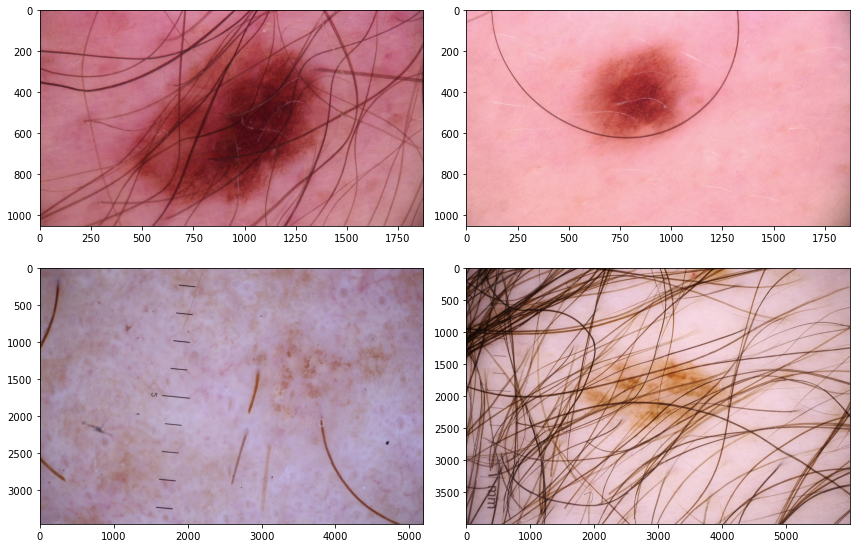

In [18]:
train_dir = "/kaggle/input/siim-isic-melanoma-classification/jpeg/train/"

plt.figure(figsize = (12, 8))
for i in range(4) : 
    plt.subplot(2, 2, i + 1) 
    image = cv2.imread(os.path.join(train_dir, random_images[i]))
    # cv2 reads images in BGR format. Hence we convert it to RGB
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    plt.imshow(image, cmap = "gray")
    plt.grid(False)
# Automatically adjust subplot parameters to give specified padding.
plt.tight_layout()